### Time Series Analysis on Corona Virus Data


https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [77]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
import pickle
import os.path
from datetime import datetime
import pyarrow
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from pylab import rcParams
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
warnings.filterwarnings("ignore")
%matplotlib inline



In [78]:
# Dynamic parameters
data_dir  = '../data/' + str(datetime.date(datetime.now()))
agg_file  = 'agg_data_{}.parquet.gzip'.format(datetime.date(datetime.now()))
trend_file  = 'trend_{}.csv'.format(datetime.date(datetime.now()))

# import data
agg_df = pd.read_parquet(os.path.join(data_dir, agg_file))
daily_df = pd.read_csv(os.path.join(data_dir, trend_file), index_col=[0])

# Convert types
for col in ['confirmed', 'deaths', 'recovered']:
    agg_df[col] = agg_df[col].replace('', 0).astype(int)

agg_df['date'] = agg_df['date'].astype('datetime64[ns]')
daily_df['date'] = daily_df['date'].astype('datetime64[ns]')

#set ggplot style
plt.style.use('ggplot')

#### Display range of days

#### Plotting

In [79]:
# Plots
def plot_scatter_2vars(tmp_df, x_col, y_col):
    tmp_df.plot(x=x_col, y=y_col, style='o')  
    plt.title('Scatter plot for correlation of ' + x_col + ' and ' + y_col)  
    plt.xlabel(x_col)  
    plt.ylabel(y_col)  
    plt.show()

def plot_scatter_1var(tmp_df, col):
    
    tmp_df.groupby(['date'])[col].sum().plot(figsize=(10, 6), style='o') 
    plt.title('Regression on accumalitive Sum of Confirmed Cases')  
    plt.xlabel('date')  
    plt.ylabel('confirmed cases')  
    plt.show()
    
# Plot and save trendline graph
def plot_trend_line(tmp_df, col):
    fig, ax = plt.subplots(figsize=(13,8))
    tmp_df.groupby('date')[[col]].sum().plot(ax=ax)
    fig = ax.get_figure()

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [80]:
#Calculate range of trend data
def time_range(tmp_df):
    print('...', tmp_df['date'].min().date(), 'to',  tmp_df['date'].max().date())
    print('...', tmp_df['date'].min() - tmp_df['date'].max())
    print('\n')

print('Calulcating date ranges...\n')
print('time series data:')
time_range(agg_df)

print('trend data:')
time_range(daily_df)

Calulcating date ranges...

time series data:
... 2020-01-22 to 2020-02-23
... -32 days +00:00:00


trend data:
... 2020-01-22 to 2020-02-23
... -32 days +00:00:00




In [152]:
daily_df.head()

,new_confirmed_cases,new_deaths,new_recoveries,date,confirmed_MA,deaths_MA,recovered_MA,confirmed_exp_MA,deaths_exp_MA,recovered_exp_MA,currently_infected,delta
0,555,17,28,2020-01-22,NaN,NaN,NaN,555.000000,17.000000,28.000000,510,-45
1,98,1,2,2020-01-23,326.5,9.0,15.0,212.250000,5.000000,8.500000,605,-48
2,288,8,6,2020-01-24,193.0,4.5,4.0,264.692308,7.076923,6.769231,879,-62
3,497,16,3,2020-01-25,392.5,12.0,4.5,421.500000,13.100000,4.225000,1357,-81
4,680,14,13,2020-01-26,588.5,15.0,8.0,594.545455,13.702479,10.099174,2010,-108


In [153]:
daily_df.new_confirmed_cases.describe().to_frame()

,new_confirmed_cases
count,33.000000
mean,2387.363636
std,2700.266964
min,98.000000
25%,587.000000
50%,2027.000000
75%,3034.000000
max,15001.000000


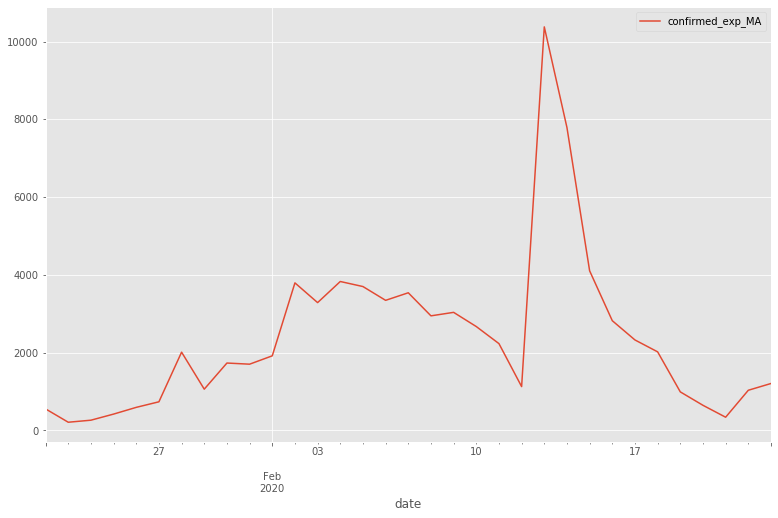

In [157]:
plot_trend_line(daily_df, 'confirmed_exp_MA')

### Baseline Prediction

In [187]:
daily_df.confirmed_exp_MA[:3]

0    555.000000
1    212.250000
2    264.692308
Name: confirmed_exp_MA, dtype: float64

In [193]:
# Create lagged dataset
values = pd.DataFrame(daily_df.confirmed_exp_MA.values)
df = pd.concat([values, values.shift(1)], axis=1)
df.columns = ['t', 't+1']
df.head()

,t,t+1
0,555.000000,NaN
1,212.250000,555.000000
2,264.692308,212.250000
3,421.500000,264.692308
4,594.545455,421.500000


In [203]:
## Create train and test set
X = df.values
train_size = int(len(X) * 0.75) # Take the first 2 thirds as training
train, test = X[1:train_size], X[train_size:] #1 onward because there is a NaN

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [204]:
# np.sqrt(mean_squared_error(train_X, train_y))

In [207]:
predictions = list()
for x in test_X:
	predictions.append(x)

test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 1925638.508


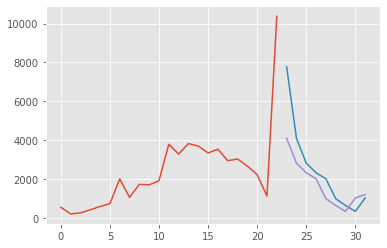

In [208]:
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

#### Our basline metric
- .80 training

In [211]:
# A squared value is not interpretable, so you get the sqaure root to get the mean error value
print('BASELINE SCORE FOR MODELS: %.3f' % np.sqrt(test_score))

BASELINE SCORE FOR MODELS: 1387.674


## ARIMA

#### Autoregressive (p) integrated (d) moving average (q)
- Autoregressive -> previous value is correlated with the future value
- integrated -> order of difference (delta between t and t-1)
    - Can be denoted by (d), so d=1, d=2 and so on
    - tries remove the error
- moving average -> smoothing

In [212]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [221]:
# df

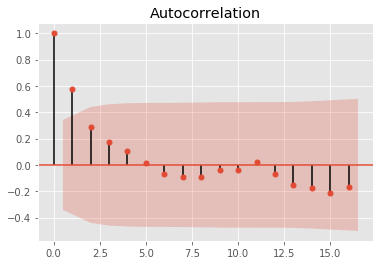

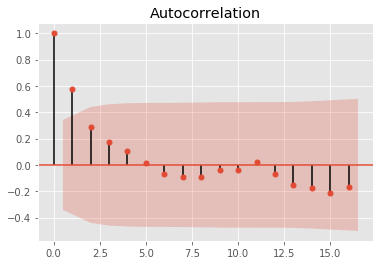

In [222]:
plot_acf(df['t']) # Identify q

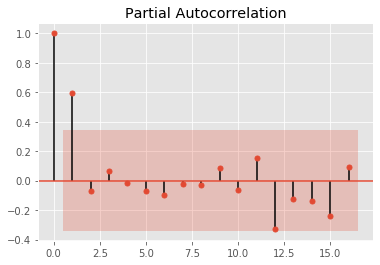

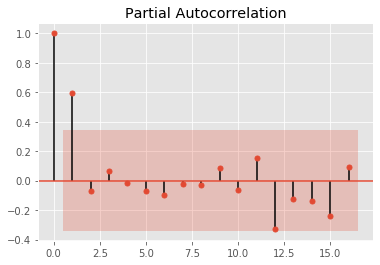

In [223]:
plot_pacf(df['t']) # Identift p

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, )


model.aic()